In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
with open("get-metric.csv", 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split(",")) for l in temp_f.readlines() ]
print(col_count)
### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]

### Read csv
df = pd.read_csv("get-metric.csv", header=None, delimiter=",", names=column_names).T
df.columns = df.iloc[0]
df = df[1:]
df /=1000

[1125, 1839, 2085, 2701, 2290, 1866, 965, 1, 1]


In [46]:
clients = [int(x[6:]) for x in df.columns]
upbound = []
for col in df.columns:
    upbound.append(df[col].quantile(0.99))

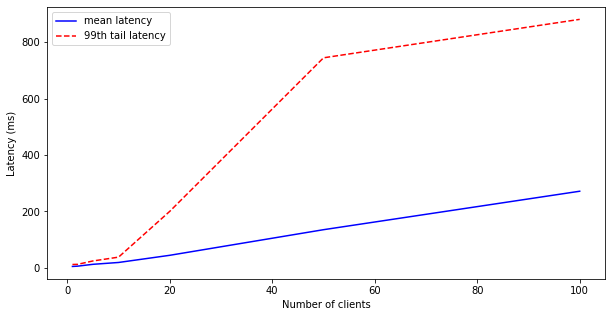

In [47]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(clients, df.mean().values, 'b', label='mean latency')
plt.plot(clients, upbound, '--r', label='99th tail latency')
plt.xlabel("Number of clients")
plt.ylabel("Latency (ms)")
plt.legend(loc="upper left")
plt.show()

In [36]:
df.client200.hist(bins=30)

AttributeError: 'DataFrame' object has no attribute 'client200'